In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10


In [3]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


In [4]:
train_images.shape


(50000, 32, 32, 3)

In [5]:
test_images.shape


(10000, 32, 32, 3)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [7]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [8]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss=tf.losses.sparse_categorical_crossentropy,
              optimizer=RMSprop(learning_rate=0.001), metrics=['acc'])


In [9]:
history = model.fit(
    train_images/255,
    train_labels,
    epochs=10,
    validation_data=(test_images/255, test_labels)
)


Epoch 1/10
1563/1563 [==============================] - 31s 19ms/step - loss: 1.6179 - acc: 0.4084 - val_loss: 1.3202 - val_acc: 0.5275
Epoch 2/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.2484 - acc: 0.5578 - val_loss: 1.2229 - val_acc: 0.5658
Epoch 3/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.1011 - acc: 0.6128 - val_loss: 1.1059 - val_acc: 0.6161
Epoch 4/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.0039 - acc: 0.6483 - val_loss: 1.0885 - val_acc: 0.6197
Epoch 5/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.9293 - acc: 0.6737 - val_loss: 1.0038 - val_acc: 0.6570
Epoch 6/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8772 - acc: 0.6951 - val_loss: 1.0435 - val_acc: 0.6361
Epoch 7/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.8319 - acc: 0.7098 - val_loss: 1.0274 - val_acc: 0.6515
Epoch 8/10
1563/1563 [==========================

In [12]:
import numpy as np
# import file
from keras.preprocessing import image
name = ["airplane", "automobile", "bird", "cat",
        "deer", "dog", "frog", "horse", "ship", "trucl"]
file_path = input("Enter the path for the image you want to classify:")
img = image.load_img(file_path, target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=20)
print("It's a "+name[np.argmax(classes[0])]+".")


It's a automobile.


Text(0.5, 1.0, 'Training and validation loss')

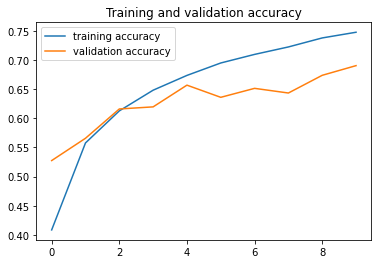

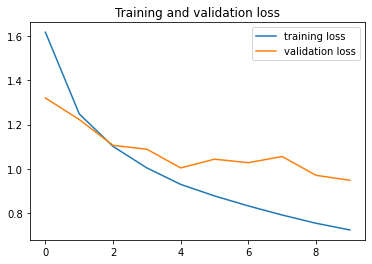

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title('Training and validation loss')
